# CNN

In [ ]:
import torch
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
import io
import sys
import copy
import torch.optim as optim

from torchsummary import summary
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.optim import lr_scheduler


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)


100%|██████████| 26.4M/26.4M [00:06<00:00, 4.12MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 319kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.50MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.6MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
print(train_data)
print()
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


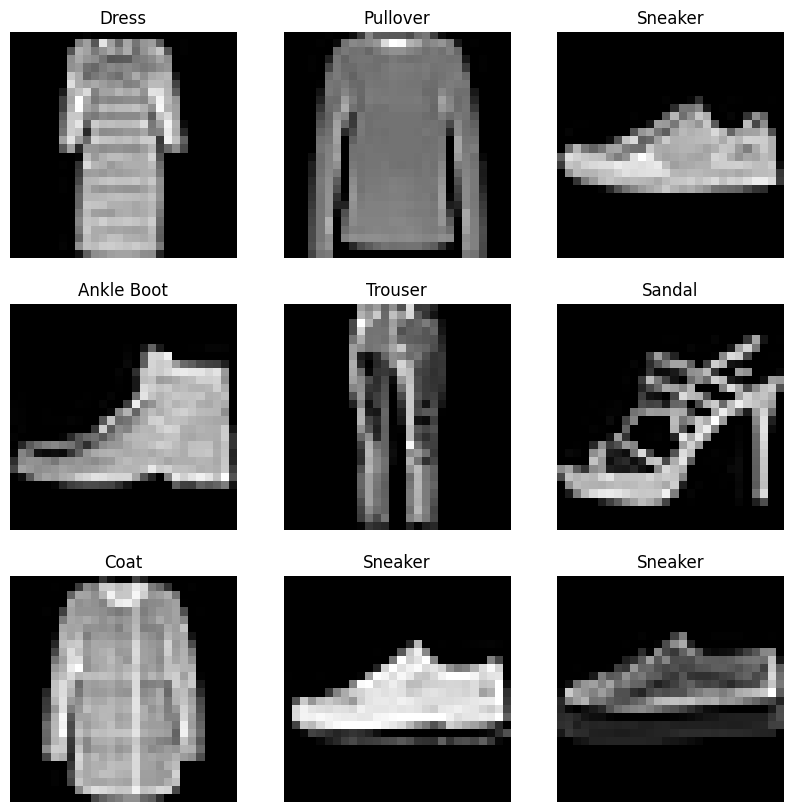

In [ ]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [ ]:
batch_size = 64

In [ ]:
# Dataloader
train_dataloader =torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader =torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)


In [ ]:
# Ver imagen and label del dataloader
train_features, train_labels = next(iter(train_dataloader))

Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


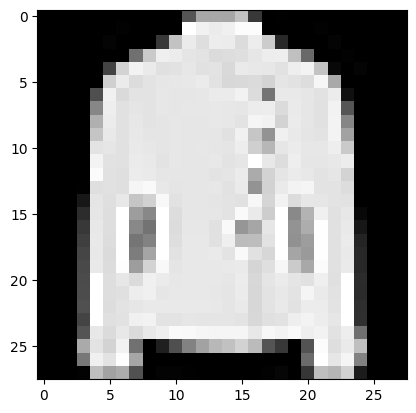

Label: 4 - Coat


In [ ]:
# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[20]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[20]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label} - {labels_map[int(label)]}")


#### Parámetros e Hiperparámetros

Parámetros para la capa de Convolución ([Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))

In [ ]:
# Parámetros que dejo con sus valores default:
# dilation (1 -> Espacio entre los elementos del kernel)
# groups (1 -> Para convoluciones agrupadas)
# bias (True -> Agrega término de sesgo)
# device (None) - dtype (None)

conv_in_channels = 1        # (int) Número de canales en la imagen de entrada.
conv_out_channels= 8        # (int) Número de canales de salida generados por la convolución.
conv_kernel_size = 5        # (int) Tamaño del filtro n (nxn)
conv_stride = 1,            # (int) Paso del filtro. Default = 1
conv_padding = 0            # (int) Default = 0 / str: 'same' - 'valid'
conv_padding_mode = 'zeros' # Define el modo de padding. Default = 'zeros' ('reflect', 'replicate', 'circular')


Parámetros para la capa de Pooling ([MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html))

In [ ]:
# Parámetros que dejo con sus valores default:
# ceil_mode (False -> Aplica Floor para determinar el tamaño de la imagen)
# return_indices (False -> No necesito unpooling posterior)
# dilation (1 -> Aplica a otras capas de pooling no a MaxPool2d)


pool_kernel_size = 3       # (int) Tamaño del filtro n (nxn)
pool_stride = 1            # (int) Paso del filtro - Default = None.
pool_padding = 0           # (int) Default = 0.


#### Definición del bloque de convolución

In [ ]:
def conv_block(conv_in_channels, conv_out_channels, conv_kernel_size, conv_stride, conv_padding, conv_padding_mode,
               pool_kernel_size, pool_stride, pool_padding):

    return torch.nn.Sequential(

        # Convolución
        torch.nn.Conv2d(in_channels = conv_in_channels,
                        out_channels = conv_out_channels,
                        kernel_size = conv_kernel_size,
                        stride = conv_stride,
                        padding = conv_padding,
                        dilation = 1,
                        groups = 1,
                        bias = True,
                        padding_mode = conv_padding_mode
                        ),

        # Activación - Tangente Hiperbólica
        torch.nn.Tanh(),


        # Pooling
        torch.nn.MaxPool2d(kernel_size = pool_kernel_size,
                           stride = pool_stride,
                           padding = pool_padding
                           )
    )


#### Arquitecturas de la red

A continuación, defino 5 arquitecturas diferentes variando hiperparámetros para comparar luego su rendimiento.

##### Arquitectura 1

* Cantidad de bloques de convolución: 2
* Tamaño del kernel para la capa de convolución: 7x7
* Tamaño del kernel para la capa de pooling: 3x3
* Canales de salida de la convolución: 8
* Paso - Convolución: 1
* Paso - Pooling: 1
* Padding - Convolución: 1 - zeros
* Pading - Pooling: 0
* Dropout : 0.3

In [ ]:
class CNN1 (torch.nn.Module):

  def __init__(self):

    super().__init__()

    conv_kernel_size = 7
    conv_stride = 1
    conv_padding = 1
    conv_padding_mode = 'zeros'

    pool_kernel_size = 3
    pool_stride = 1
    pool_padding = 0

    self.conv1 = conv_block(conv_in_channels = 1,
                            conv_out_channels = 8,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv1_out = None

    self.drop = torch.nn.Dropout2d(p=0.3)

    self.conv2 = conv_block(conv_in_channels = 8,
                            conv_out_channels = 16,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv2_out = None

    self.fc = torch.nn.Linear(16 * 16 * 16, 10)

    print('ARQUITECTURA 1:')
    print('\n')
    print(self)
    print('\n')
    print('Número total de parámetros a entrenar: ', sum(p.numel() for p in self.parameters() if p.requires_grad))
    print('\n')


  def forward (self, x):

    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    y = self.conv2_out.view(self.conv2_out.shape[0], -1)
    y = self.fc(y)

    return y

In [ ]:
model1 = CNN1()

ARQUITECTURA 1:


CNN1(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)


Número total de parámetros a entrenar:  47658




In [ ]:
summary(model1.to(device),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 24, 24]             400
              Tanh-2            [-1, 8, 24, 24]               0
         MaxPool2d-3            [-1, 8, 22, 22]               0
         Dropout2d-4            [-1, 8, 22, 22]               0
            Conv2d-5           [-1, 16, 18, 18]           6,288
              Tanh-6           [-1, 16, 18, 18]               0
         MaxPool2d-7           [-1, 16, 16, 16]               0
         Dropout2d-8           [-1, 16, 16, 16]               0
            Linear-9                   [-1, 10]          40,970
Total params: 47,658
Trainable params: 47,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.27
Params size (MB): 0.18
Estimated Total Size (MB): 0.46
---------------------------------------------

In [ ]:
def getSummaryDetails(model):

  # Redirigir la salida estándar a una variable
  old_stdout = sys.stdout
  sys.stdout = mystdout = io.StringIO()

  # Llamar a summary
  summary(model, input_size=(1, 28, 28))

  # Recuperar la salida y restaurar la salida estándar
  sys.stdout = old_stdout
  summary_output = mystdout.getvalue()

  # Procesar summary_output
  lines = summary_output.split('\n')

  # Buscar las líneas relevantes
  for line in lines:
      if "Total params:" in line:
          total_params = line.split(":")[1].strip()
          total_params = int(total_params.replace(',', ''))
      elif "Trainable params:" in line:
          trainable_params = line.split(":")[1].strip()
          trainable_params = int(trainable_params.replace(',', ''))
      elif "Non-trainable params:" in line:
          non_trainable_params = line.split(":")[1].strip()
          non_trainable_params = int(non_trainable_params.replace(',', ''))
      elif "Input size (MB):" in line:
          input_size_mb = line.split(":")[1].strip()
          input_size_mb = float(input_size_mb.replace(',', ''))
      elif "Forward/backward pass size (MB):" in line:
          forward_backward_size_mb = line.split(":")[1].strip()
          forward_backward_size_mb = float(forward_backward_size_mb.replace(',', ''))
      elif "Params size (MB):" in line:
          params_size_mb = line.split(":")[1].strip()
          params_size_mb = float(params_size_mb.replace(',', ''))
      elif "Estimated Total Size (MB):" in line:
          estimated_total_size_mb = line.split(":")[1].strip()
          estimated_total_size_mb = float(estimated_total_size_mb.replace(',', ''))

  return ( total_params, trainable_params, non_trainable_params,
          input_size_mb, forward_backward_size_mb, params_size_mb, estimated_total_size_mb)


In [ ]:
(
    total_params_1, trainable_params_1, non_trainable_params_1,
    input_size_mb_1, forward_backward_size_mb_1, params_size_mb_1, estimated_total_size_mb_1

) = getSummaryDetails(model1)


##### Arquitectura 2

* Cantidad de bloques de convolución: 2
* Tamaño del kernel para la capa de convolución: 3x3
* Tamaño del kernel para la capa de pooling: 3x3
* Canales de salida de la convolución: 16
* Paso - Convolución: 2
* Paso - Pooling: 1
* Padding - Convolución: 0 - zeros
* Pading - Pooling: 0
* Dropout : 0.5

In [ ]:
class CNN2 (torch.nn.Module):

  def __init__(self):

    super().__init__()

    conv_kernel_size = 3
    conv_stride = 2
    conv_padding = 0
    conv_padding_mode = 'zeros'

    pool_kernel_size = 3
    pool_stride = 1
    pool_padding = 0

    self.conv1 = conv_block(conv_in_channels = 1,
                            conv_out_channels = 16,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv1_out = None

    self.drop = torch.nn.Dropout2d(p=0.5)

    self.conv2 = conv_block(conv_in_channels = 16,
                            conv_out_channels = 32,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv2_out = None

    self.fc = torch.nn.Linear(32 * 3 * 3, 10)

    print('ARQUITECTURA 2:')
    print('\n')
    print(self)
    print('\n')
    print('Número total de parámetros a entrenar: ', sum(p.numel() for p in self.parameters() if p.requires_grad))
    print('\n')

  def forward (self, x):

    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    y = self.conv2_out.view(self.conv2_out.shape[0], -1)
    y = self.fc(y)

    return y

In [ ]:
model2 = CNN2()

summary(model2.to(device),(1, 28, 28))

(
    total_params_2, trainable_params_2, non_trainable_params_2,
    input_size_mb_2, forward_backward_size_mb_2, params_size_mb_2, estimated_total_size_mb_2

) = getSummaryDetails(model2)


ARQUITECTURA 2:


CNN2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.5, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=288, out_features=10, bias=True)
)


Número total de parámetros a entrenar:  7690


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
              Tanh-2           [-1, 16, 13, 13]               0
         MaxPool2d-3           [-1, 16, 11, 11]               0
         Dropout2d-4           [-1, 16, 11, 11]               0
            Conv2d-5             [-1, 32, 5, 5]           4,640
   

##### Arquitectura 3

* Cantidad de bloques de convolución: 3
* Tamaño del kernel para la capa de convolución: 5x5
* Tamaño del kernel para la capa de pooling: 3x3
* Canales de salida de la convolución: 8
* Paso - Convolución: 1
* Paso - Pooling: 1
* Padding - Convolución: 1 - replicate
* Pading - Pooling: 0
* Dropout : 0.3

In [ ]:
class CNN3 (torch.nn.Module):

  def __init__(self):

    super().__init__()

    conv_kernel_size = 5
    conv_stride = 1
    conv_padding = 1
    conv_padding_mode = 'replicate'

    pool_kernel_size = 3
    pool_stride = 1
    pool_padding = 0


    self.conv1 = conv_block(conv_in_channels = 1,
                            conv_out_channels = 8,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv1_out = None

    self.drop = torch.nn.Dropout2d(p=0.3)

    self.conv2 = conv_block(conv_in_channels = 8,
                            conv_out_channels = 16,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv2_out = None

    self.conv3 = conv_block(conv_in_channels = 16,
                            conv_out_channels = 32,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv3_out = None

    self.fc = torch.nn.Linear(32 * 16 * 16, 10)

    print('ARQUITECTURA 3:')
    print('\n')
    print(self)
    print('\n')
    print('Número total de parámetros a entrenar: ', sum(p.numel() for p in self.parameters() if p.requires_grad))
    print('\n')


  def forward (self, x):

    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    self.conv3_out = self.drop(self.conv3(self.conv2_out))
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)

    return y

In [ ]:
model3 = CNN3()

summary(model3.to(device),(1, 28, 28))

(
    total_params_3, trainable_params_3, non_trainable_params_3,
    input_size_mb_3, forward_backward_size_mb_3, params_size_mb_3, estimated_total_size_mb_3

) = getSummaryDetails(model3)



ARQUITECTURA 3:


CNN3(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)


Número total de parámetros a entrenar:  98186


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2

##### Arquitectura 4

* Cantidad de bloques de convolución: 3
* Tamaño del kernel para la capa de convolución: 5x5
* Tamaño del kernel para la capa de pooling: 5x5
* Canales de salida de la convolución: 8
* Paso - Convolución: 1
* Paso - Pooling: 2
* Padding - Convolución: 2 - zeros
* Pading - Pooling: 0
* Dropout : 0.4


In [ ]:
class CNN4 (torch.nn.Module):

  def __init__(self):

    super().__init__()

    conv_kernel_size = 5
    conv_stride = 1
    conv_padding = 2
    conv_padding_mode = 'zeros'

    pool_kernel_size = 5
    pool_stride = 1
    pool_padding = 0


    self.conv1 = conv_block(conv_in_channels = 1,
                            conv_out_channels = 8,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv1_out = None

    self.drop = torch.nn.Dropout2d(p=0.4)

    self.conv2 = conv_block(conv_in_channels = 8,
                            conv_out_channels = 16,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv2_out = None

    self.conv3 = conv_block(conv_in_channels = 16,
                            conv_out_channels = 32,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv3_out = None

    self.fc = torch.nn.Linear(32 * 16 * 16, 10)

    print('ARQUITECTURA 4:')
    print('\n')
    print(self)
    print('\n')
    print('Número total de parámetros a entrenar: ', sum(p.numel() for p in self.parameters() if p.requires_grad))
    print('\n')


  def forward (self, x):

    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    self.conv3_out = self.drop(self.conv3(self.conv2_out))
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)

    return y

In [ ]:
model4 = CNN4()

summary(model4.to(device),(1, 28, 28))

(
    total_params_4, trainable_params_4, non_trainable_params_4,
    input_size_mb_4, forward_backward_size_mb_4, params_size_mb_4, estimated_total_size_mb_4

) = getSummaryDetails(model4)


ARQUITECTURA 4:


CNN4(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.4, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)


Número total de parámetros a entrenar:  98186


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
              Tanh-2     

##### Arquitectura 5

* Cantidad de bloques de convolución: 4
* Tamaño del kernel para la capa de convolución: 3x3
* Tamaño del kernel para la capa de pooling: 2x2
* Canales de salida de la convolución: 4
* Paso - Convolución: 2
* Paso - Pooling: 2
* Padding - Convolución: 1 - replicate
* Pading - Pooling: 1
* Dropout : 0.0

In [ ]:
class CNN5 (torch.nn.Module):

  def __init__(self):

    super().__init__()

    conv_kernel_size = 3
    conv_stride = 2
    conv_padding = 1
    conv_padding_mode = 'replicate'

    pool_kernel_size = 2
    pool_stride = 2
    pool_padding = 1


    self.conv1 = conv_block(conv_in_channels = 1,
                            conv_out_channels = 4,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv1_out = None

    self.drop = torch.nn.Dropout2d(p=0)

    self.conv2 = conv_block(conv_in_channels = 4,
                            conv_out_channels = 8,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv2_out = None

    self.conv3 = conv_block(conv_in_channels = 8,
                            conv_out_channels = 16,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv3_out = None

    self.conv4 = conv_block(conv_in_channels = 16,
                            conv_out_channels = 32,
                            conv_kernel_size = conv_kernel_size,
                            conv_stride = conv_stride,
                            conv_padding = conv_padding,
                            conv_padding_mode = conv_padding_mode,
                            pool_kernel_size = pool_kernel_size,
                            pool_stride = pool_stride,
                            pool_padding = pool_padding)

    self.conv4_out = None

    self.fc = torch.nn.Linear(32 * 1 * 1, 10)

    print('ARQUITECTURA 5:')
    print('\n')
    print(self)
    print('\n')
    print('Número total de parámetros a entrenar: ', sum(p.numel() for p in self.parameters() if p.requires_grad))
    print('\n')


  def forward (self, x):

    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    self.conv3_out = self.drop(self.conv3(self.conv2_out))
    self.conv4_out = self.drop(self.conv4(self.conv3_out))
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)

    return y

In [ ]:
model5 = CNN5()

summary(model5.to(device),(1, 28, 28))

(
    total_params_5, trainable_params_5, non_trainable_params_5,
    input_size_mb_5, forward_backward_size_mb_5, params_size_mb_5, estimated_total_size_mb_5

) = getSummaryDetails(model5)


ARQUITECTURA 5:


CNN5(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=replicate)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=replicate)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=replicate)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=replicate)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=32, out_fe

### Ejecución

In [ ]:
def fit (model, train_dataloader, test_dataloader, epochs=15):

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    criterion = torch.nn.CrossEntropyLoss()

    epoch_t_loss = []
    epoch_t_acc = []
    epoch_v_loss = []
    epoch_v_acc = []

    for epoch in range(1, epochs+1):

        # Entrenamiento
        model.train()

        train_loss, train_acc = [], []

        bar = tqdm(train_dataloader)

        for batch in bar:

            X, y = batch

            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            y_hat = model(X)

            loss = criterion(y_hat, y)

            loss.backward()

            optimizer.step()

            train_loss.append(loss.item())

            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)

            train_acc.append(acc)

            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))

        epoch_t_acc.append(np.mean(train_acc))


        # Validación
        bar = tqdm(test_dataloader)
        val_loss, val_acc = [], []

        model.eval()

        with torch.no_grad():

            for batch in bar:
                X, y = batch

                X, y = X.to(device), y.to(device)

                y_hat = model(X)

                loss = criterion(y_hat, y)

                val_loss.append(loss.item())

                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)

                val_acc.append(acc)

                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        print(f"\nEpoch {epoch}/{epochs}")
        print(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))

        epoch_v_acc.append(np.mean(val_acc))


    return epoch_t_loss, epoch_v_loss, epoch_t_acc, epoch_v_acc

In [ ]:
def graphResults (graph1, graph2):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)

    for y in graph1['values']:
      plt.plot(y['axy'], y['color'])

    plt.title(graph1['title'])
    plt.legend(graph1['legend'])
    plt.grid()

    plt.subplot(1, 2, 2)

    for y in graph2['values']:
      plt.plot(y['axy'], y['color'])

    plt.title(graph2['title'])
    plt.legend(graph2['legend'])
    plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
epochs = 50

#### Arquitectura 1

In [ ]:
(
    epoch_t_loss_1, epoch_v_loss_1,
    epoch_t_acc_1, epoch_v_acc_1

    ) = fit(model1, train_dataloader, test_dataloader, epochs=epochs)


val_loss 0.58949 val_acc 0.78234: 100%|██████████| 157/157 [00:01<00:00, 79.96it/s]



Epoch 1/50
loss 0.85876 val_loss 0.58949 acc 0.70123 val_acc 0.78234


val_loss 0.51668 val_acc 0.80852: 100%|██████████| 157/157 [00:02<00:00, 70.25it/s]



Epoch 2/50
loss 0.58790 val_loss 0.51668 acc 0.78735 val_acc 0.80852


val_loss 0.47710 val_acc 0.82683: 100%|██████████| 157/157 [00:02<00:00, 77.64it/s]



Epoch 3/50
loss 0.53344 val_loss 0.47710 acc 0.80875 val_acc 0.82683


val_loss 0.45493 val_acc 0.83957: 100%|██████████| 157/157 [00:01<00:00, 80.74it/s]



Epoch 4/50
loss 0.49870 val_loss 0.45493 acc 0.82101 val_acc 0.83957


val_loss 0.43694 val_acc 0.84445: 100%|██████████| 157/157 [00:01<00:00, 82.52it/s]



Epoch 5/50
loss 0.48008 val_loss 0.43694 acc 0.82939 val_acc 0.84445


val_loss 0.43173 val_acc 0.84504: 100%|██████████| 157/157 [00:02<00:00, 72.95it/s]



Epoch 6/50
loss 0.46318 val_loss 0.43173 acc 0.83619 val_acc 0.84504


val_loss 0.41063 val_acc 0.85539: 100%|██████████| 157/157 [00:02<00:00, 73.34it/s]



Epoch 7/50
loss 0.45002 val_loss 0.41063 acc 0.84100 val_acc 0.85539


val_loss 0.40093 val_acc 0.85967: 100%|██████████| 157/157 [00:01<00:00, 86.31it/s]



Epoch 8/50
loss 0.43994 val_loss 0.40093 acc 0.84553 val_acc 0.85967


val_loss 0.40141 val_acc 0.85738: 100%|██████████| 157/157 [00:01<00:00, 84.55it/s]



Epoch 9/50
loss 0.43094 val_loss 0.40141 acc 0.84731 val_acc 0.85738


val_loss 0.39087 val_acc 0.86087: 100%|██████████| 157/157 [00:02<00:00, 75.12it/s]



Epoch 10/50
loss 0.42591 val_loss 0.39087 acc 0.84915 val_acc 0.86087


val_loss 0.38672 val_acc 0.86216: 100%|██████████| 157/157 [00:02<00:00, 65.63it/s]



Epoch 11/50
loss 0.41873 val_loss 0.38672 acc 0.85366 val_acc 0.86216


val_loss 0.38287 val_acc 0.86425: 100%|██████████| 157/157 [00:01<00:00, 83.25it/s]



Epoch 12/50
loss 0.41329 val_loss 0.38287 acc 0.85319 val_acc 0.86425


val_loss 0.37995 val_acc 0.86714: 100%|██████████| 157/157 [00:01<00:00, 81.29it/s]



Epoch 13/50
loss 0.40600 val_loss 0.37995 acc 0.85498 val_acc 0.86714


val_loss 0.37857 val_acc 0.86475: 100%|██████████| 157/157 [00:01<00:00, 82.30it/s]



Epoch 14/50
loss 0.40308 val_loss 0.37857 acc 0.85673 val_acc 0.86475


val_loss 0.37131 val_acc 0.86684: 100%|██████████| 157/157 [00:02<00:00, 62.32it/s]



Epoch 15/50
loss 0.39883 val_loss 0.37131 acc 0.85764 val_acc 0.86684


val_loss 0.36302 val_acc 0.87142: 100%|██████████| 157/157 [00:01<00:00, 80.74it/s]



Epoch 16/50
loss 0.39576 val_loss 0.36302 acc 0.86011 val_acc 0.87142


val_loss 0.36263 val_acc 0.87172: 100%|██████████| 157/157 [00:01<00:00, 81.44it/s]



Epoch 17/50
loss 0.39058 val_loss 0.36263 acc 0.86016 val_acc 0.87172


val_loss 0.35779 val_acc 0.87321: 100%|██████████| 157/157 [00:01<00:00, 79.65it/s]



Epoch 18/50
loss 0.38677 val_loss 0.35779 acc 0.86154 val_acc 0.87321


val_loss 0.35726 val_acc 0.87172: 100%|██████████| 157/157 [00:02<00:00, 71.04it/s]



Epoch 19/50
loss 0.38543 val_loss 0.35726 acc 0.86351 val_acc 0.87172


val_loss 0.36292 val_acc 0.86853: 100%|██████████| 157/157 [00:02<00:00, 75.10it/s]



Epoch 20/50
loss 0.38171 val_loss 0.36292 acc 0.86362 val_acc 0.86853


val_loss 0.35760 val_acc 0.87311: 100%|██████████| 157/157 [00:01<00:00, 81.99it/s]



Epoch 21/50
loss 0.37971 val_loss 0.35760 acc 0.86379 val_acc 0.87311


val_loss 0.35246 val_acc 0.87191: 100%|██████████| 157/157 [00:01<00:00, 81.34it/s]



Epoch 22/50
loss 0.37548 val_loss 0.35246 acc 0.86575 val_acc 0.87191


val_loss 0.35111 val_acc 0.87669: 100%|██████████| 157/157 [00:02<00:00, 72.70it/s]



Epoch 23/50
loss 0.37317 val_loss 0.35111 acc 0.86840 val_acc 0.87669


val_loss 0.34923 val_acc 0.87669: 100%|██████████| 157/157 [00:02<00:00, 67.17it/s]



Epoch 24/50
loss 0.36917 val_loss 0.34923 acc 0.86717 val_acc 0.87669


val_loss 0.34947 val_acc 0.87699: 100%|██████████| 157/157 [00:01<00:00, 80.83it/s]



Epoch 25/50
loss 0.36890 val_loss 0.34947 acc 0.86922 val_acc 0.87699


val_loss 0.34954 val_acc 0.87679: 100%|██████████| 157/157 [00:01<00:00, 80.74it/s]



Epoch 26/50
loss 0.36562 val_loss 0.34954 acc 0.86930 val_acc 0.87679


val_loss 0.34520 val_acc 0.87809: 100%|██████████| 157/157 [00:01<00:00, 81.24it/s]



Epoch 27/50
loss 0.36438 val_loss 0.34520 acc 0.87032 val_acc 0.87809


val_loss 0.34329 val_acc 0.87858: 100%|██████████| 157/157 [00:02<00:00, 61.78it/s]



Epoch 28/50
loss 0.36147 val_loss 0.34329 acc 0.87120 val_acc 0.87858


val_loss 0.33908 val_acc 0.87809: 100%|██████████| 157/157 [00:01<00:00, 80.49it/s]



Epoch 29/50
loss 0.36071 val_loss 0.33908 acc 0.87024 val_acc 0.87809


val_loss 0.33926 val_acc 0.87938: 100%|██████████| 157/157 [00:01<00:00, 79.57it/s]



Epoch 30/50
loss 0.35685 val_loss 0.33926 acc 0.87283 val_acc 0.87938


val_loss 0.33190 val_acc 0.88147: 100%|██████████| 157/157 [00:02<00:00, 69.10it/s]



Epoch 31/50
loss 0.35748 val_loss 0.33190 acc 0.87275 val_acc 0.88147


val_loss 0.34582 val_acc 0.87351: 100%|██████████| 157/157 [00:02<00:00, 62.11it/s]



Epoch 32/50
loss 0.35574 val_loss 0.34582 acc 0.87295 val_acc 0.87351


val_loss 0.32825 val_acc 0.88535: 100%|██████████| 157/157 [00:01<00:00, 79.82it/s]



Epoch 33/50
loss 0.35267 val_loss 0.32825 acc 0.87467 val_acc 0.88535


val_loss 0.33214 val_acc 0.88276: 100%|██████████| 157/157 [00:01<00:00, 82.22it/s]



Epoch 34/50
loss 0.34792 val_loss 0.33214 acc 0.87493 val_acc 0.88276


val_loss 0.33311 val_acc 0.88047: 100%|██████████| 157/157 [00:01<00:00, 79.70it/s]



Epoch 35/50
loss 0.34735 val_loss 0.33311 acc 0.87807 val_acc 0.88047


val_loss 0.33404 val_acc 0.87998: 100%|██████████| 157/157 [00:02<00:00, 61.91it/s]



Epoch 36/50
loss 0.34932 val_loss 0.33404 acc 0.87420 val_acc 0.87998


val_loss 0.33262 val_acc 0.88475: 100%|██████████| 157/157 [00:01<00:00, 80.32it/s]



Epoch 37/50
loss 0.34641 val_loss 0.33262 acc 0.87658 val_acc 0.88475


val_loss 0.32716 val_acc 0.88296: 100%|██████████| 157/157 [00:01<00:00, 81.03it/s]



Epoch 38/50
loss 0.34317 val_loss 0.32716 acc 0.87830 val_acc 0.88296


val_loss 0.32974 val_acc 0.88117: 100%|██████████| 157/157 [00:01<00:00, 82.03it/s]



Epoch 39/50
loss 0.33985 val_loss 0.32974 acc 0.87803 val_acc 0.88117


val_loss 0.32271 val_acc 0.88326: 100%|██████████| 157/157 [00:02<00:00, 62.33it/s]



Epoch 40/50
loss 0.34142 val_loss 0.32271 acc 0.87763 val_acc 0.88326


val_loss 0.32902 val_acc 0.88227: 100%|██████████| 157/157 [00:01<00:00, 81.28it/s]



Epoch 41/50
loss 0.34009 val_loss 0.32902 acc 0.87798 val_acc 0.88227


val_loss 0.32251 val_acc 0.88336: 100%|██████████| 157/157 [00:01<00:00, 79.77it/s]



Epoch 42/50
loss 0.33684 val_loss 0.32251 acc 0.88036 val_acc 0.88336


val_loss 0.33715 val_acc 0.87868: 100%|██████████| 157/157 [00:01<00:00, 82.41it/s]



Epoch 43/50
loss 0.33643 val_loss 0.33715 acc 0.87976 val_acc 0.87868


val_loss 0.31566 val_acc 0.88635: 100%|██████████| 157/157 [00:02<00:00, 67.08it/s]



Epoch 44/50
loss 0.33697 val_loss 0.31566 acc 0.88008 val_acc 0.88635


val_loss 0.31760 val_acc 0.88734: 100%|██████████| 157/157 [00:01<00:00, 79.93it/s]



Epoch 45/50
loss 0.33430 val_loss 0.31760 acc 0.88028 val_acc 0.88734


val_loss 0.32341 val_acc 0.88445: 100%|██████████| 157/157 [00:01<00:00, 79.65it/s]



Epoch 46/50
loss 0.33653 val_loss 0.32341 acc 0.88100 val_acc 0.88445


val_loss 0.32142 val_acc 0.88585: 100%|██████████| 157/157 [00:01<00:00, 80.80it/s]



Epoch 47/50
loss 0.33175 val_loss 0.32142 acc 0.88176 val_acc 0.88585


val_loss 0.31498 val_acc 0.88704: 100%|██████████| 157/157 [00:02<00:00, 61.55it/s]



Epoch 48/50
loss 0.32963 val_loss 0.31498 acc 0.88151 val_acc 0.88704


val_loss 0.31891 val_acc 0.88475: 100%|██████████| 157/157 [00:01<00:00, 80.51it/s]



Epoch 49/50
loss 0.33145 val_loss 0.31891 acc 0.88108 val_acc 0.88475


val_loss 0.31360 val_acc 0.88854: 100%|██████████| 157/157 [00:01<00:00, 78.76it/s]


Epoch 50/50
loss 0.32924 val_loss 0.31360 acc 0.88090 val_acc 0.88854


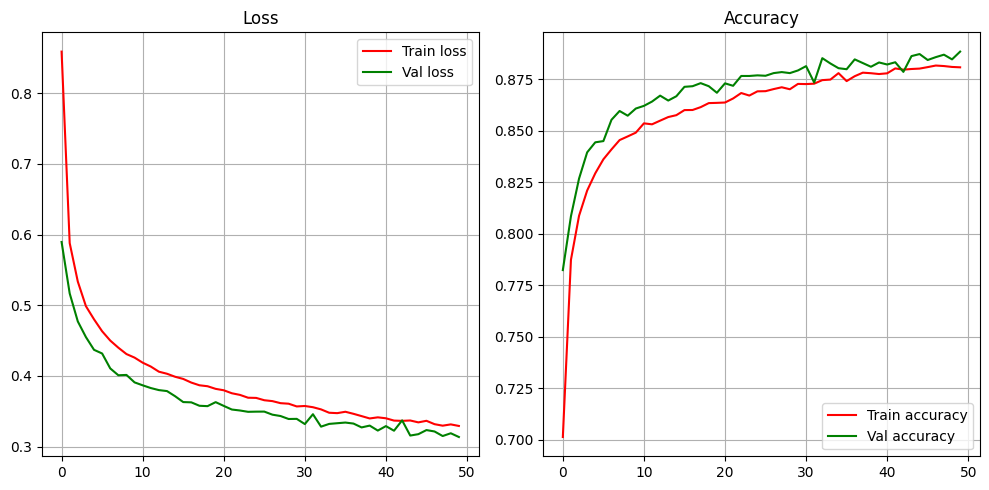

In [ ]:
graph_loss = {
    'values': [{
        'axy': epoch_t_loss_1,
        'color': 'r'
    },
    {
        'axy': epoch_v_loss_1,
        'color': 'g'
    }],
    'title': "Loss",
    'legend': ['Train loss', 'Val loss'],
}

graph_accuracy = {
    'values': [{
        'axy': epoch_t_acc_1,
        'color': 'r'
    },
    {
        'axy': epoch_v_acc_1,
        'color': 'g'
    }],
    'title': "Accuracy",
    'legend': ['Train accuracy', 'Val accuracy']
}

graphResults (graph_loss, graph_accuracy)

#### Arquitectura 2

In [ ]:
(
    epoch_t_loss_2, epoch_v_loss_2,
    epoch_t_acc_2, epoch_v_acc_2

    ) = fit(model2, train_dataloader, test_dataloader, epochs=epochs)

val_loss 1.08204 val_acc 0.64421: 100%|██████████| 157/157 [00:01<00:00, 83.35it/s]



Epoch 1/50
loss 1.67464 val_loss 1.08204 acc 0.42850 val_acc 0.64421


val_loss 0.88047 val_acc 0.68770: 100%|██████████| 157/157 [00:02<00:00, 60.00it/s]



Epoch 2/50
loss 1.07082 val_loss 0.88047 acc 0.63286 val_acc 0.68770


val_loss 0.78911 val_acc 0.71188: 100%|██████████| 157/157 [00:01<00:00, 82.25it/s]



Epoch 3/50
loss 0.92422 val_loss 0.78911 acc 0.67844 val_acc 0.71188


val_loss 0.73016 val_acc 0.72980: 100%|██████████| 157/157 [00:01<00:00, 80.56it/s]



Epoch 4/50
loss 0.84639 val_loss 0.73016 acc 0.70381 val_acc 0.72980


val_loss 0.69024 val_acc 0.74313: 100%|██████████| 157/157 [00:01<00:00, 79.89it/s]



Epoch 5/50
loss 0.79782 val_loss 0.69024 acc 0.71833 val_acc 0.74313


val_loss 0.66564 val_acc 0.74781: 100%|██████████| 157/157 [00:01<00:00, 80.92it/s]



Epoch 6/50
loss 0.76060 val_loss 0.66564 acc 0.72899 val_acc 0.74781


val_loss 0.64182 val_acc 0.75866: 100%|██████████| 157/157 [00:02<00:00, 64.09it/s]



Epoch 7/50
loss 0.73716 val_loss 0.64182 acc 0.73604 val_acc 0.75866


val_loss 0.62689 val_acc 0.76592: 100%|██████████| 157/157 [00:01<00:00, 82.35it/s]



Epoch 8/50
loss 0.71882 val_loss 0.62689 acc 0.74182 val_acc 0.76592


val_loss 0.61720 val_acc 0.76722: 100%|██████████| 157/157 [00:01<00:00, 81.65it/s]



Epoch 9/50
loss 0.70485 val_loss 0.61720 acc 0.74722 val_acc 0.76722


val_loss 0.60658 val_acc 0.77020: 100%|██████████| 157/157 [00:01<00:00, 83.12it/s]



Epoch 10/50
loss 0.69002 val_loss 0.60658 acc 0.75165 val_acc 0.77020


val_loss 0.59585 val_acc 0.78025: 100%|██████████| 157/157 [00:02<00:00, 77.52it/s]



Epoch 11/50
loss 0.68250 val_loss 0.59585 acc 0.75398 val_acc 0.78025


val_loss 0.58658 val_acc 0.78623: 100%|██████████| 157/157 [00:02<00:00, 66.76it/s]



Epoch 12/50
loss 0.67319 val_loss 0.58658 acc 0.75843 val_acc 0.78623


val_loss 0.57857 val_acc 0.78662: 100%|██████████| 157/157 [00:01<00:00, 80.51it/s]



Epoch 13/50
loss 0.66586 val_loss 0.57857 acc 0.76081 val_acc 0.78662


val_loss 0.57360 val_acc 0.79061: 100%|██████████| 157/157 [00:01<00:00, 80.98it/s]



Epoch 14/50
loss 0.65683 val_loss 0.57360 acc 0.76334 val_acc 0.79061


val_loss 0.56651 val_acc 0.79319: 100%|██████████| 157/157 [00:01<00:00, 81.77it/s]



Epoch 15/50
loss 0.65160 val_loss 0.56651 acc 0.76419 val_acc 0.79319


val_loss 0.56164 val_acc 0.79319: 100%|██████████| 157/157 [00:02<00:00, 64.28it/s]



Epoch 16/50
loss 0.64278 val_loss 0.56164 acc 0.76797 val_acc 0.79319


val_loss 0.55753 val_acc 0.79459: 100%|██████████| 157/157 [00:01<00:00, 80.92it/s]



Epoch 17/50
loss 0.64009 val_loss 0.55753 acc 0.77104 val_acc 0.79459


val_loss 0.55299 val_acc 0.79837: 100%|██████████| 157/157 [00:01<00:00, 80.54it/s]



Epoch 18/50
loss 0.63569 val_loss 0.55299 acc 0.77146 val_acc 0.79837


val_loss 0.54872 val_acc 0.79887: 100%|██████████| 157/157 [00:01<00:00, 83.35it/s]



Epoch 19/50
loss 0.63224 val_loss 0.54872 acc 0.77392 val_acc 0.79887


val_loss 0.54662 val_acc 0.80046: 100%|██████████| 157/157 [00:02<00:00, 78.28it/s]



Epoch 20/50
loss 0.62598 val_loss 0.54662 acc 0.77442 val_acc 0.80046


val_loss 0.54199 val_acc 0.80165: 100%|██████████| 157/157 [00:02<00:00, 64.23it/s]



Epoch 21/50
loss 0.62064 val_loss 0.54199 acc 0.77662 val_acc 0.80165


val_loss 0.53982 val_acc 0.80245: 100%|██████████| 157/157 [00:01<00:00, 79.97it/s]



Epoch 22/50
loss 0.61916 val_loss 0.53982 acc 0.77907 val_acc 0.80245


val_loss 0.53872 val_acc 0.80334: 100%|██████████| 157/157 [00:01<00:00, 79.91it/s]



Epoch 23/50
loss 0.61629 val_loss 0.53872 acc 0.77767 val_acc 0.80334


val_loss 0.53203 val_acc 0.80623: 100%|██████████| 157/157 [00:01<00:00, 82.05it/s]



Epoch 24/50
loss 0.61296 val_loss 0.53203 acc 0.77982 val_acc 0.80623


val_loss 0.52988 val_acc 0.80742: 100%|██████████| 157/157 [00:02<00:00, 71.03it/s]



Epoch 25/50
loss 0.61032 val_loss 0.52988 acc 0.78080 val_acc 0.80742


val_loss 0.52775 val_acc 0.80583: 100%|██████████| 157/157 [00:02<00:00, 75.32it/s]



Epoch 26/50
loss 0.60604 val_loss 0.52775 acc 0.78385 val_acc 0.80583


val_loss 0.52616 val_acc 0.80683: 100%|██████████| 157/157 [00:01<00:00, 78.61it/s]



Epoch 27/50
loss 0.60256 val_loss 0.52616 acc 0.78430 val_acc 0.80683


val_loss 0.52232 val_acc 0.80832: 100%|██████████| 157/157 [00:01<00:00, 80.66it/s]



Epoch 28/50
loss 0.59939 val_loss 0.52232 acc 0.78591 val_acc 0.80832


val_loss 0.51725 val_acc 0.81190: 100%|██████████| 157/157 [00:02<00:00, 75.03it/s]



Epoch 29/50
loss 0.59817 val_loss 0.51725 acc 0.78586 val_acc 0.81190


val_loss 0.51573 val_acc 0.81369: 100%|██████████| 157/157 [00:02<00:00, 63.26it/s]



Epoch 30/50
loss 0.59440 val_loss 0.51573 acc 0.78886 val_acc 0.81369


val_loss 0.51366 val_acc 0.81330: 100%|██████████| 157/157 [00:01<00:00, 79.81it/s]



Epoch 31/50
loss 0.59324 val_loss 0.51366 acc 0.78865 val_acc 0.81330


val_loss 0.51234 val_acc 0.81330: 100%|██████████| 157/157 [00:01<00:00, 79.83it/s]



Epoch 32/50
loss 0.58683 val_loss 0.51234 acc 0.78913 val_acc 0.81330


val_loss 0.51026 val_acc 0.81578: 100%|██████████| 157/157 [00:02<00:00, 62.08it/s]



Epoch 33/50
loss 0.58705 val_loss 0.51026 acc 0.78980 val_acc 0.81578


val_loss 0.50852 val_acc 0.81459: 100%|██████████| 157/157 [00:02<00:00, 61.33it/s]



Epoch 34/50
loss 0.58481 val_loss 0.50852 acc 0.79151 val_acc 0.81459


val_loss 0.50772 val_acc 0.81549: 100%|██████████| 157/157 [00:01<00:00, 79.67it/s]



Epoch 35/50
loss 0.58326 val_loss 0.50772 acc 0.79206 val_acc 0.81549


val_loss 0.50408 val_acc 0.81768: 100%|██████████| 157/157 [00:01<00:00, 80.34it/s]



Epoch 36/50
loss 0.58155 val_loss 0.50408 acc 0.79306 val_acc 0.81768


val_loss 0.50141 val_acc 0.81787: 100%|██████████| 157/157 [00:01<00:00, 79.23it/s]



Epoch 37/50
loss 0.57761 val_loss 0.50141 acc 0.79391 val_acc 0.81787


val_loss 0.50181 val_acc 0.81738: 100%|██████████| 157/157 [00:02<00:00, 67.97it/s]



Epoch 38/50
loss 0.57780 val_loss 0.50181 acc 0.79366 val_acc 0.81738


val_loss 0.49928 val_acc 0.81758: 100%|██████████| 157/157 [00:02<00:00, 75.22it/s]



Epoch 39/50
loss 0.57468 val_loss 0.49928 acc 0.79538 val_acc 0.81758


val_loss 0.49599 val_acc 0.81937: 100%|██████████| 157/157 [00:02<00:00, 76.16it/s]



Epoch 40/50
loss 0.57559 val_loss 0.49599 acc 0.79331 val_acc 0.81937


val_loss 0.49609 val_acc 0.81917: 100%|██████████| 157/157 [00:01<00:00, 78.82it/s]



Epoch 41/50
loss 0.57221 val_loss 0.49609 acc 0.79634 val_acc 0.81917


val_loss 0.49414 val_acc 0.81947: 100%|██████████| 157/157 [00:02<00:00, 73.74it/s]



Epoch 42/50
loss 0.57021 val_loss 0.49414 acc 0.79736 val_acc 0.81947


val_loss 0.49385 val_acc 0.82136: 100%|██████████| 157/157 [00:02<00:00, 68.17it/s]



Epoch 43/50
loss 0.57288 val_loss 0.49385 acc 0.79513 val_acc 0.82136


val_loss 0.49111 val_acc 0.82285: 100%|██████████| 157/157 [00:01<00:00, 79.43it/s]



Epoch 44/50
loss 0.56633 val_loss 0.49111 acc 0.79889 val_acc 0.82285


val_loss 0.49003 val_acc 0.82195: 100%|██████████| 157/157 [00:01<00:00, 78.57it/s]



Epoch 45/50
loss 0.56545 val_loss 0.49003 acc 0.79894 val_acc 0.82195


val_loss 0.48830 val_acc 0.82195: 100%|██████████| 157/157 [00:01<00:00, 79.79it/s]



Epoch 46/50
loss 0.56612 val_loss 0.48830 acc 0.79914 val_acc 0.82195


val_loss 0.48793 val_acc 0.82076: 100%|██████████| 157/157 [00:02<00:00, 70.12it/s]



Epoch 47/50
loss 0.56400 val_loss 0.48793 acc 0.79921 val_acc 0.82076


val_loss 0.48682 val_acc 0.82265: 100%|██████████| 157/157 [00:02<00:00, 74.63it/s]



Epoch 48/50
loss 0.55917 val_loss 0.48682 acc 0.79959 val_acc 0.82265


val_loss 0.48550 val_acc 0.82365: 100%|██████████| 157/157 [00:01<00:00, 79.55it/s]



Epoch 49/50
loss 0.56213 val_loss 0.48550 acc 0.80014 val_acc 0.82365


val_loss 0.48308 val_acc 0.82375: 100%|██████████| 157/157 [00:02<00:00, 69.39it/s]



Epoch 50/50
loss 0.55740 val_loss 0.48308 acc 0.80121 val_acc 0.82375


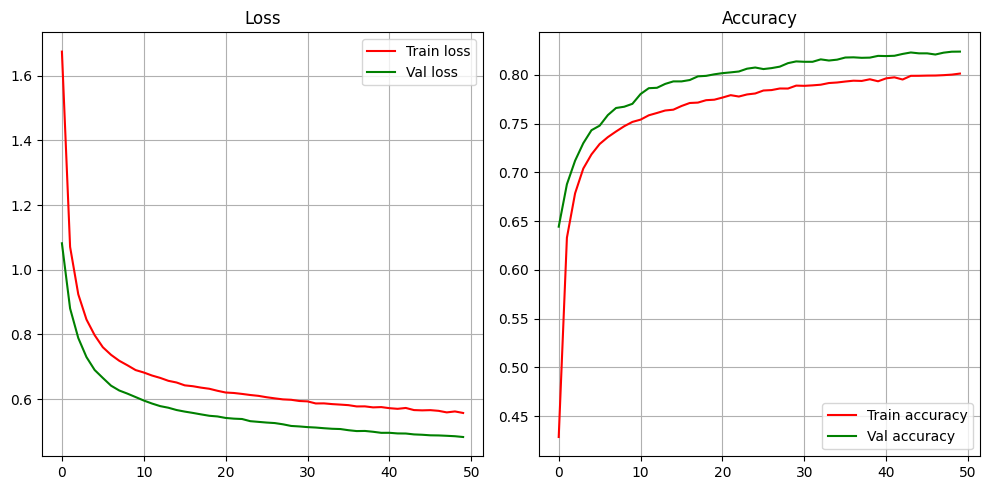

In [ ]:
graph_loss = {
    'values': [{
        'axy': epoch_t_loss_2,
        'color': 'r'
    },
    {
        'axy': epoch_v_loss_2,
        'color': 'g'
    }],
    'title': "Loss",
    'legend': ['Train loss', 'Val loss'],
}

graph_accuracy = {
    'values': [{
        'axy': epoch_t_acc_2,
        'color': 'r'
    },
    {
        'axy': epoch_v_acc_2,
        'color': 'g'
    }],
    'title': "Accuracy",
    'legend': ['Train accuracy', 'Val accuracy']
}

graphResults (graph_loss, graph_accuracy)

#### Arquitectura 3

In [ ]:
(
    epoch_t_loss_3, epoch_v_loss_3,
    epoch_t_acc_3, epoch_v_acc_3

    ) = fit(model3, train_dataloader, test_dataloader, epochs=epochs)

val_loss 0.57457 val_acc 0.77906: 100%|██████████| 157/157 [00:02<00:00, 64.17it/s]



Epoch 1/50
loss 0.82908 val_loss 0.57457 acc 0.70446 val_acc 0.77906


val_loss 0.51244 val_acc 0.80523: 100%|██████████| 157/157 [00:01<00:00, 79.04it/s]



Epoch 2/50
loss 0.58569 val_loss 0.51244 acc 0.78631 val_acc 0.80523


val_loss 0.46910 val_acc 0.82952: 100%|██████████| 157/157 [00:01<00:00, 78.66it/s]



Epoch 3/50
loss 0.52609 val_loss 0.46910 acc 0.81043 val_acc 0.82952


val_loss 0.44176 val_acc 0.83838: 100%|██████████| 157/157 [00:02<00:00, 72.91it/s]



Epoch 4/50
loss 0.49449 val_loss 0.44176 acc 0.82189 val_acc 0.83838


val_loss 0.44001 val_acc 0.84096: 100%|██████████| 157/157 [00:01<00:00, 79.78it/s]



Epoch 5/50
loss 0.47090 val_loss 0.44001 acc 0.82864 val_acc 0.84096


val_loss 0.41539 val_acc 0.85161: 100%|██████████| 157/157 [00:02<00:00, 76.92it/s]



Epoch 6/50
loss 0.45295 val_loss 0.41539 acc 0.83782 val_acc 0.85161


val_loss 0.39874 val_acc 0.85987: 100%|██████████| 157/157 [00:02<00:00, 77.14it/s]



Epoch 7/50
loss 0.43894 val_loss 0.39874 acc 0.84202 val_acc 0.85987


val_loss 0.38528 val_acc 0.86266: 100%|██████████| 157/157 [00:02<00:00, 78.45it/s]



Epoch 8/50
loss 0.42635 val_loss 0.38528 acc 0.84680 val_acc 0.86266


val_loss 0.37626 val_acc 0.86435: 100%|██████████| 157/157 [00:02<00:00, 67.62it/s]



Epoch 9/50
loss 0.41553 val_loss 0.37626 acc 0.85116 val_acc 0.86435


val_loss 0.36554 val_acc 0.86923: 100%|██████████| 157/157 [00:01<00:00, 79.46it/s]



Epoch 10/50
loss 0.40977 val_loss 0.36554 acc 0.85198 val_acc 0.86923


val_loss 0.36215 val_acc 0.87301: 100%|██████████| 157/157 [00:02<00:00, 77.42it/s]



Epoch 11/50
loss 0.39926 val_loss 0.36215 acc 0.85556 val_acc 0.87301


val_loss 0.35956 val_acc 0.87211: 100%|██████████| 157/157 [00:02<00:00, 60.68it/s]



Epoch 12/50
loss 0.39278 val_loss 0.35956 acc 0.85884 val_acc 0.87211


val_loss 0.35249 val_acc 0.87341: 100%|██████████| 157/157 [00:02<00:00, 77.94it/s]



Epoch 13/50
loss 0.38548 val_loss 0.35249 acc 0.86247 val_acc 0.87341


val_loss 0.34327 val_acc 0.87779: 100%|██████████| 157/157 [00:01<00:00, 79.77it/s]



Epoch 14/50
loss 0.38109 val_loss 0.34327 acc 0.86367 val_acc 0.87779


val_loss 0.34259 val_acc 0.87898: 100%|██████████| 157/157 [00:02<00:00, 65.26it/s]



Epoch 15/50
loss 0.37639 val_loss 0.34259 acc 0.86517 val_acc 0.87898


val_loss 0.35486 val_acc 0.87500: 100%|██████████| 157/157 [00:01<00:00, 79.85it/s]



Epoch 16/50
loss 0.37272 val_loss 0.35486 acc 0.86526 val_acc 0.87500


val_loss 0.33225 val_acc 0.88127: 100%|██████████| 157/157 [00:02<00:00, 76.48it/s]



Epoch 17/50
loss 0.36812 val_loss 0.33225 acc 0.86764 val_acc 0.88127


val_loss 0.33287 val_acc 0.88067: 100%|██████████| 157/157 [00:02<00:00, 77.30it/s]



Epoch 18/50
loss 0.36595 val_loss 0.33287 acc 0.86787 val_acc 0.88067


val_loss 0.33105 val_acc 0.88286: 100%|██████████| 157/157 [00:01<00:00, 78.84it/s]



Epoch 19/50
loss 0.36364 val_loss 0.33105 acc 0.87022 val_acc 0.88286


val_loss 0.33120 val_acc 0.88306: 100%|██████████| 157/157 [00:02<00:00, 69.46it/s]



Epoch 20/50
loss 0.35594 val_loss 0.33120 acc 0.87127 val_acc 0.88306


val_loss 0.32363 val_acc 0.88426: 100%|██████████| 157/157 [00:01<00:00, 78.84it/s]



Epoch 21/50
loss 0.35410 val_loss 0.32363 acc 0.87255 val_acc 0.88426


val_loss 0.32861 val_acc 0.88027: 100%|██████████| 157/157 [00:02<00:00, 77.98it/s]



Epoch 22/50
loss 0.35158 val_loss 0.32861 acc 0.87203 val_acc 0.88027


val_loss 0.31627 val_acc 0.88834: 100%|██████████| 157/157 [00:02<00:00, 59.82it/s]



Epoch 23/50
loss 0.35059 val_loss 0.31627 acc 0.87342 val_acc 0.88834


val_loss 0.31545 val_acc 0.88704: 100%|██████████| 157/157 [00:01<00:00, 80.20it/s]



Epoch 24/50
loss 0.34744 val_loss 0.31545 acc 0.87425 val_acc 0.88704


val_loss 0.31794 val_acc 0.88684: 100%|██████████| 157/157 [00:02<00:00, 78.15it/s]



Epoch 25/50
loss 0.34201 val_loss 0.31794 acc 0.87685 val_acc 0.88684


val_loss 0.31615 val_acc 0.88774: 100%|██████████| 157/157 [00:02<00:00, 71.81it/s]



Epoch 26/50
loss 0.34231 val_loss 0.31615 acc 0.87615 val_acc 0.88774


val_loss 0.30644 val_acc 0.89271: 100%|██████████| 157/157 [00:02<00:00, 78.09it/s]



Epoch 27/50
loss 0.33695 val_loss 0.30644 acc 0.87901 val_acc 0.89271


val_loss 0.31467 val_acc 0.88854: 100%|██████████| 157/157 [00:02<00:00, 69.59it/s]



Epoch 28/50
loss 0.33617 val_loss 0.31467 acc 0.87870 val_acc 0.88854


val_loss 0.30258 val_acc 0.89281: 100%|██████████| 157/157 [00:02<00:00, 78.26it/s]



Epoch 29/50
loss 0.33366 val_loss 0.30258 acc 0.88000 val_acc 0.89281


val_loss 0.30325 val_acc 0.89152: 100%|██████████| 157/157 [00:02<00:00, 77.15it/s]



Epoch 30/50
loss 0.33312 val_loss 0.30325 acc 0.88003 val_acc 0.89152


val_loss 0.31841 val_acc 0.88127: 100%|██████████| 157/157 [00:02<00:00, 60.90it/s]



Epoch 31/50
loss 0.33020 val_loss 0.31841 acc 0.88053 val_acc 0.88127


val_loss 0.30752 val_acc 0.89112: 100%|██████████| 157/157 [00:02<00:00, 77.19it/s]



Epoch 32/50
loss 0.32800 val_loss 0.30752 acc 0.88011 val_acc 0.89112


val_loss 0.30590 val_acc 0.89182: 100%|██████████| 157/157 [00:02<00:00, 76.82it/s]



Epoch 33/50
loss 0.32697 val_loss 0.30590 acc 0.88223 val_acc 0.89182


val_loss 0.30130 val_acc 0.89142: 100%|██████████| 157/157 [00:02<00:00, 68.29it/s]



Epoch 34/50
loss 0.32169 val_loss 0.30130 acc 0.88308 val_acc 0.89142


val_loss 0.30062 val_acc 0.89351: 100%|██████████| 157/157 [00:02<00:00, 78.18it/s]



Epoch 35/50
loss 0.32226 val_loss 0.30062 acc 0.88370 val_acc 0.89351


val_loss 0.31517 val_acc 0.88326: 100%|██████████| 157/157 [00:02<00:00, 69.04it/s]



Epoch 36/50
loss 0.31855 val_loss 0.31517 acc 0.88448 val_acc 0.88326


val_loss 0.29597 val_acc 0.89580: 100%|██████████| 157/157 [00:02<00:00, 78.17it/s]



Epoch 37/50
loss 0.31748 val_loss 0.29597 acc 0.88438 val_acc 0.89580


val_loss 0.29019 val_acc 0.89620: 100%|██████████| 157/157 [00:02<00:00, 77.55it/s]



Epoch 38/50
loss 0.31811 val_loss 0.29019 acc 0.88453 val_acc 0.89620


val_loss 0.30149 val_acc 0.89381: 100%|██████████| 157/157 [00:02<00:00, 63.70it/s]



Epoch 39/50
loss 0.31257 val_loss 0.30149 acc 0.88609 val_acc 0.89381


val_loss 0.29552 val_acc 0.89520: 100%|██████████| 157/157 [00:02<00:00, 77.44it/s]



Epoch 40/50
loss 0.31484 val_loss 0.29552 acc 0.88679 val_acc 0.89520


val_loss 0.28967 val_acc 0.89829: 100%|██████████| 157/157 [00:02<00:00, 77.04it/s]



Epoch 41/50
loss 0.30987 val_loss 0.28967 acc 0.88721 val_acc 0.89829


val_loss 0.29748 val_acc 0.89610: 100%|██████████| 157/157 [00:02<00:00, 72.87it/s]



Epoch 42/50
loss 0.30966 val_loss 0.29748 acc 0.88796 val_acc 0.89610


val_loss 0.30312 val_acc 0.88654: 100%|██████████| 157/157 [00:02<00:00, 78.47it/s]



Epoch 43/50
loss 0.30970 val_loss 0.30312 acc 0.88746 val_acc 0.88654


val_loss 0.29177 val_acc 0.89630: 100%|██████████| 157/157 [00:02<00:00, 69.29it/s]



Epoch 44/50
loss 0.30760 val_loss 0.29177 acc 0.88674 val_acc 0.89630


val_loss 0.28767 val_acc 0.89719: 100%|██████████| 157/157 [00:02<00:00, 77.33it/s]



Epoch 45/50
loss 0.31065 val_loss 0.28767 acc 0.88739 val_acc 0.89719


val_loss 0.29396 val_acc 0.89192: 100%|██████████| 157/157 [00:02<00:00, 77.28it/s]



Epoch 46/50
loss 0.30491 val_loss 0.29396 acc 0.88851 val_acc 0.89192


val_loss 0.28887 val_acc 0.89490: 100%|██████████| 157/157 [00:02<00:00, 64.89it/s]



Epoch 47/50
loss 0.30464 val_loss 0.28887 acc 0.88926 val_acc 0.89490


val_loss 0.28546 val_acc 0.89879: 100%|██████████| 157/157 [00:02<00:00, 77.80it/s]



Epoch 48/50
loss 0.30275 val_loss 0.28546 acc 0.88986 val_acc 0.89879


val_loss 0.29131 val_acc 0.89451: 100%|██████████| 157/157 [00:02<00:00, 76.14it/s]



Epoch 49/50
loss 0.29991 val_loss 0.29131 acc 0.88978 val_acc 0.89451


val_loss 0.28687 val_acc 0.89699: 100%|██████████| 157/157 [00:02<00:00, 77.10it/s]


Epoch 50/50
loss 0.29939 val_loss 0.28687 acc 0.89119 val_acc 0.89699


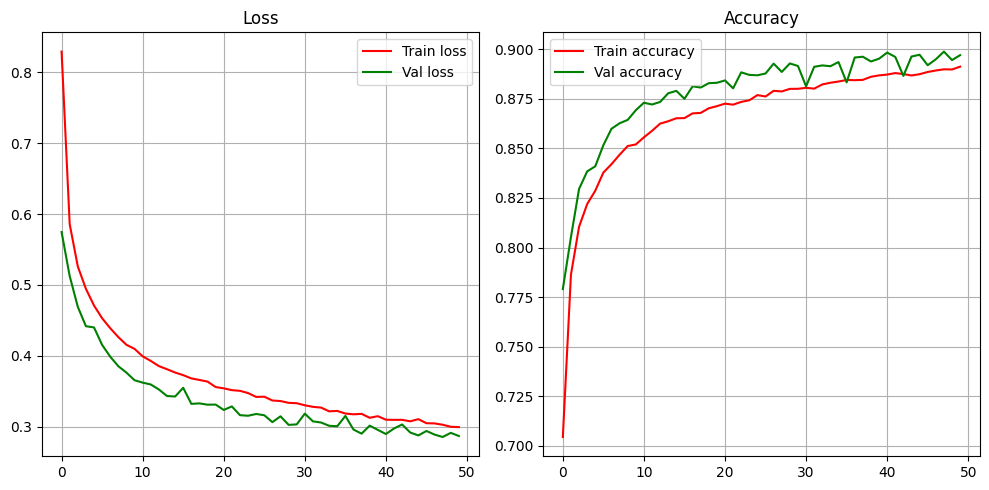

In [ ]:
graph_loss = {
    'values': [{
        'axy': epoch_t_loss_3,
        'color': 'r'
    },
    {
        'axy': epoch_v_loss_3,
        'color': 'g'
    }],
    'title': "Loss",
    'legend': ['Train loss', 'Val loss'],
}

graph_accuracy = {
    'values': [{
        'axy': epoch_t_acc_3,
        'color': 'r'
    },
    {
        'axy': epoch_v_acc_3,
        'color': 'g'
    }],
    'title': "Accuracy",
    'legend': ['Train accuracy', 'Val accuracy']
}

graphResults (graph_loss, graph_accuracy)

#### Arquitectura 4

In [ ]:
(
    epoch_t_loss_4, epoch_v_loss_4,
    epoch_t_acc_4, epoch_v_acc_4

    ) = fit(model4, train_dataloader, test_dataloader, epochs=epochs)

val_loss 0.59740 val_acc 0.77826: 100%|██████████| 157/157 [00:01<00:00, 79.80it/s]



Epoch 1/50
loss 0.99671 val_loss 0.59740 acc 0.64364 val_acc 0.77826


val_loss 0.53322 val_acc 0.80125: 100%|██████████| 157/157 [00:02<00:00, 62.77it/s]



Epoch 2/50
loss 0.68482 val_loss 0.53322 acc 0.75088 val_acc 0.80125


val_loss 0.52712 val_acc 0.80374: 100%|██████████| 157/157 [00:01<00:00, 82.11it/s]



Epoch 3/50
loss 0.61843 val_loss 0.52712 acc 0.77725 val_acc 0.80374


val_loss 0.47748 val_acc 0.82544: 100%|██████████| 157/157 [00:01<00:00, 80.15it/s]



Epoch 4/50
loss 0.58204 val_loss 0.47748 acc 0.79020 val_acc 0.82544


val_loss 0.47792 val_acc 0.82484: 100%|██████████| 157/157 [00:01<00:00, 79.11it/s]



Epoch 5/50
loss 0.55515 val_loss 0.47792 acc 0.80162 val_acc 0.82484


val_loss 0.45352 val_acc 0.83768: 100%|██████████| 157/157 [00:01<00:00, 80.70it/s]



Epoch 6/50
loss 0.53568 val_loss 0.45352 acc 0.80710 val_acc 0.83768


val_loss 0.44795 val_acc 0.83848: 100%|██████████| 157/157 [00:02<00:00, 67.77it/s]



Epoch 7/50
loss 0.51381 val_loss 0.44795 acc 0.81675 val_acc 0.83848


val_loss 0.42414 val_acc 0.84684: 100%|██████████| 157/157 [00:01<00:00, 80.21it/s]



Epoch 8/50
loss 0.50398 val_loss 0.42414 acc 0.82021 val_acc 0.84684


val_loss 0.41804 val_acc 0.84674: 100%|██████████| 157/157 [00:01<00:00, 80.44it/s]



Epoch 9/50
loss 0.49379 val_loss 0.41804 acc 0.82541 val_acc 0.84674


val_loss 0.41366 val_acc 0.85121: 100%|██████████| 157/157 [00:02<00:00, 67.99it/s]



Epoch 10/50
loss 0.48326 val_loss 0.41366 acc 0.82778 val_acc 0.85121


val_loss 0.40071 val_acc 0.85699: 100%|██████████| 157/157 [00:01<00:00, 79.56it/s]



Epoch 11/50
loss 0.47741 val_loss 0.40071 acc 0.83019 val_acc 0.85699


val_loss 0.39662 val_acc 0.85529: 100%|██████████| 157/157 [00:02<00:00, 71.06it/s]



Epoch 12/50
loss 0.46508 val_loss 0.39662 acc 0.83201 val_acc 0.85529


val_loss 0.40065 val_acc 0.85490: 100%|██████████| 157/157 [00:01<00:00, 79.55it/s]



Epoch 13/50
loss 0.45902 val_loss 0.40065 acc 0.83524 val_acc 0.85490


val_loss 0.38052 val_acc 0.86644: 100%|██████████| 157/157 [00:01<00:00, 79.52it/s]



Epoch 14/50
loss 0.45280 val_loss 0.38052 acc 0.83795 val_acc 0.86644


val_loss 0.40429 val_acc 0.84763: 100%|██████████| 157/157 [00:02<00:00, 65.12it/s]



Epoch 15/50
loss 0.44329 val_loss 0.40429 acc 0.84075 val_acc 0.84763


val_loss 0.38422 val_acc 0.86385: 100%|██████████| 157/157 [00:01<00:00, 78.94it/s]



Epoch 16/50
loss 0.44213 val_loss 0.38422 acc 0.84175 val_acc 0.86385


val_loss 0.36612 val_acc 0.86883: 100%|██████████| 157/157 [00:02<00:00, 73.55it/s]



Epoch 17/50
loss 0.43095 val_loss 0.36612 acc 0.84593 val_acc 0.86883


val_loss 0.36692 val_acc 0.87042: 100%|██████████| 157/157 [00:01<00:00, 79.58it/s]



Epoch 18/50
loss 0.42908 val_loss 0.36692 acc 0.84517 val_acc 0.87042


val_loss 0.36068 val_acc 0.87132: 100%|██████████| 157/157 [00:02<00:00, 78.23it/s]



Epoch 19/50
loss 0.42546 val_loss 0.36068 acc 0.84780 val_acc 0.87132


val_loss 0.36023 val_acc 0.87221: 100%|██████████| 157/157 [00:02<00:00, 65.33it/s]



Epoch 20/50
loss 0.42109 val_loss 0.36023 acc 0.84808 val_acc 0.87221


val_loss 0.36528 val_acc 0.86992: 100%|██████████| 157/157 [00:02<00:00, 77.98it/s]



Epoch 21/50
loss 0.41747 val_loss 0.36528 acc 0.85063 val_acc 0.86992


val_loss 0.35514 val_acc 0.87351: 100%|██████████| 157/157 [00:02<00:00, 77.38it/s]



Epoch 22/50
loss 0.41237 val_loss 0.35514 acc 0.85334 val_acc 0.87351


val_loss 0.34568 val_acc 0.87699: 100%|██████████| 157/157 [00:01<00:00, 78.87it/s]



Epoch 23/50
loss 0.40782 val_loss 0.34568 acc 0.85479 val_acc 0.87699


val_loss 0.35256 val_acc 0.87480: 100%|██████████| 157/157 [00:01<00:00, 78.71it/s]



Epoch 24/50
loss 0.40664 val_loss 0.35256 acc 0.85428 val_acc 0.87480


val_loss 0.34495 val_acc 0.87639: 100%|██████████| 157/157 [00:02<00:00, 57.00it/s]



Epoch 25/50
loss 0.40241 val_loss 0.34495 acc 0.85593 val_acc 0.87639


val_loss 0.34009 val_acc 0.88027: 100%|██████████| 157/157 [00:02<00:00, 77.36it/s]



Epoch 26/50
loss 0.40016 val_loss 0.34009 acc 0.85624 val_acc 0.88027


val_loss 0.33908 val_acc 0.87918: 100%|██████████| 157/157 [00:02<00:00, 68.26it/s]



Epoch 27/50
loss 0.39944 val_loss 0.33908 acc 0.85819 val_acc 0.87918


val_loss 0.33765 val_acc 0.88117: 100%|██████████| 157/157 [00:02<00:00, 76.90it/s]



Epoch 28/50
loss 0.39337 val_loss 0.33765 acc 0.85818 val_acc 0.88117


val_loss 0.34346 val_acc 0.87848: 100%|██████████| 157/157 [00:02<00:00, 78.25it/s]



Epoch 29/50
loss 0.39021 val_loss 0.34346 acc 0.85947 val_acc 0.87848


val_loss 0.34698 val_acc 0.87062: 100%|██████████| 157/157 [00:02<00:00, 72.26it/s]



Epoch 30/50
loss 0.38842 val_loss 0.34698 acc 0.86057 val_acc 0.87062


val_loss 0.33992 val_acc 0.88127: 100%|██████████| 157/157 [00:01<00:00, 78.78it/s]



Epoch 31/50
loss 0.38441 val_loss 0.33992 acc 0.86241 val_acc 0.88127


val_loss 0.33970 val_acc 0.87968: 100%|██████████| 157/157 [00:02<00:00, 61.52it/s]



Epoch 32/50
loss 0.38336 val_loss 0.33970 acc 0.86202 val_acc 0.87968


val_loss 0.33063 val_acc 0.88366: 100%|██████████| 157/157 [00:02<00:00, 78.02it/s]



Epoch 33/50
loss 0.38209 val_loss 0.33063 acc 0.86394 val_acc 0.88366


val_loss 0.32368 val_acc 0.88645: 100%|██████████| 157/157 [00:02<00:00, 76.88it/s]



Epoch 34/50
loss 0.37644 val_loss 0.32368 acc 0.86449 val_acc 0.88645


val_loss 0.32471 val_acc 0.88455: 100%|██████████| 157/157 [00:02<00:00, 75.65it/s]



Epoch 35/50
loss 0.37422 val_loss 0.32471 acc 0.86431 val_acc 0.88455


val_loss 0.32833 val_acc 0.88236: 100%|██████████| 157/157 [00:02<00:00, 77.06it/s]



Epoch 36/50
loss 0.37620 val_loss 0.32833 acc 0.86472 val_acc 0.88236


val_loss 0.32327 val_acc 0.88704: 100%|██████████| 157/157 [00:02<00:00, 62.60it/s]



Epoch 37/50
loss 0.37140 val_loss 0.32327 acc 0.86567 val_acc 0.88704


val_loss 0.32349 val_acc 0.88475: 100%|██████████| 157/157 [00:02<00:00, 77.99it/s]



Epoch 38/50
loss 0.36751 val_loss 0.32349 acc 0.86804 val_acc 0.88475


val_loss 0.31661 val_acc 0.88913: 100%|██████████| 157/157 [00:02<00:00, 74.68it/s]



Epoch 39/50
loss 0.36947 val_loss 0.31661 acc 0.86857 val_acc 0.88913


val_loss 0.31704 val_acc 0.88844: 100%|██████████| 157/157 [00:02<00:00, 77.37it/s]



Epoch 40/50
loss 0.36729 val_loss 0.31704 acc 0.86734 val_acc 0.88844


val_loss 0.32370 val_acc 0.88426: 100%|██████████| 157/157 [00:02<00:00, 75.67it/s]



Epoch 41/50
loss 0.36575 val_loss 0.32370 acc 0.86884 val_acc 0.88426


val_loss 0.32121 val_acc 0.88436: 100%|██████████| 157/157 [00:02<00:00, 69.66it/s]



Epoch 42/50
loss 0.36265 val_loss 0.32121 acc 0.87019 val_acc 0.88436


val_loss 0.32700 val_acc 0.88426: 100%|██████████| 157/157 [00:02<00:00, 78.08it/s]



Epoch 43/50
loss 0.36295 val_loss 0.32700 acc 0.86990 val_acc 0.88426


val_loss 0.32341 val_acc 0.88436: 100%|██████████| 157/157 [00:02<00:00, 60.97it/s]



Epoch 44/50
loss 0.36071 val_loss 0.32341 acc 0.86964 val_acc 0.88436


val_loss 0.31413 val_acc 0.88774: 100%|██████████| 157/157 [00:02<00:00, 76.16it/s]



Epoch 45/50
loss 0.35891 val_loss 0.31413 acc 0.87193 val_acc 0.88774


val_loss 0.31001 val_acc 0.88913: 100%|██████████| 157/157 [00:02<00:00, 75.28it/s]



Epoch 46/50
loss 0.35950 val_loss 0.31001 acc 0.87037 val_acc 0.88913


val_loss 0.30986 val_acc 0.88943: 100%|██████████| 157/157 [00:02<00:00, 77.68it/s]



Epoch 47/50
loss 0.35501 val_loss 0.30986 acc 0.87273 val_acc 0.88943


val_loss 0.31019 val_acc 0.88854: 100%|██████████| 157/157 [00:02<00:00, 77.68it/s]



Epoch 48/50
loss 0.35616 val_loss 0.31019 acc 0.87160 val_acc 0.88854


val_loss 0.30952 val_acc 0.89013: 100%|██████████| 157/157 [00:02<00:00, 61.44it/s]



Epoch 49/50
loss 0.35129 val_loss 0.30952 acc 0.87373 val_acc 0.89013


val_loss 0.30810 val_acc 0.88963: 100%|██████████| 157/157 [00:02<00:00, 78.13it/s]


Epoch 50/50
loss 0.35248 val_loss 0.30810 acc 0.87265 val_acc 0.88963


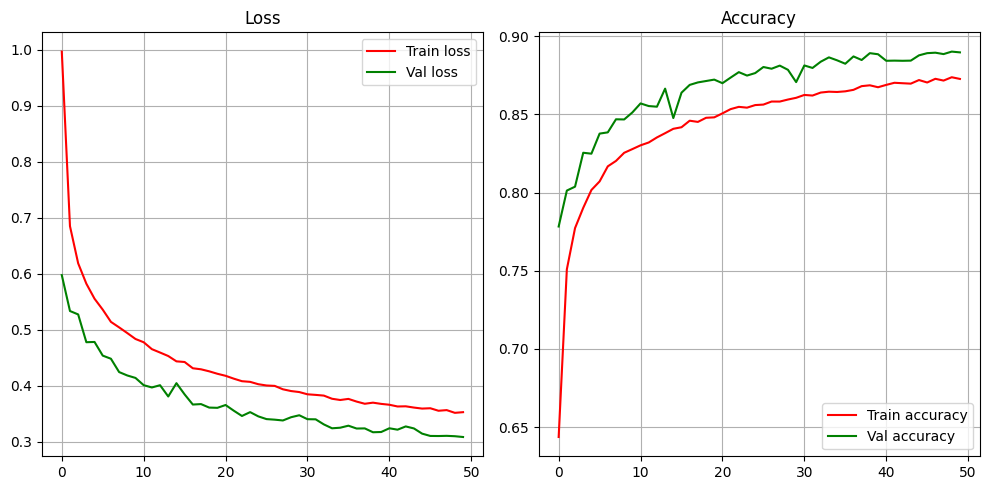

In [ ]:
graph_loss = {
    'values': [{
        'axy': epoch_t_loss_4,
        'color': 'r'
    },
    {
        'axy': epoch_v_loss_4,
        'color': 'g'
    }],
    'title': "Loss",
    'legend': ['Train loss', 'Val loss'],
}

graph_accuracy = {
    'values': [{
        'axy': epoch_t_acc_4,
        'color': 'r'
    },
    {
        'axy': epoch_v_acc_4,
        'color': 'g'
    }],
    'title': "Accuracy",
    'legend': ['Train accuracy', 'Val accuracy']
}

graphResults (graph_loss, graph_accuracy)

#### Arquitectura 5

In [ ]:
(
    epoch_t_loss_5, epoch_v_loss_5,
    epoch_t_acc_5, epoch_v_acc_5

    ) = fit(model5, train_dataloader, test_dataloader, epochs=epochs)

val_loss 1.23309 val_acc 0.61783: 100%|██████████| 157/157 [00:01<00:00, 81.57it/s]



Epoch 1/50
loss 1.69821 val_loss 1.23309 acc 0.46630 val_acc 0.61783


val_loss 0.91514 val_acc 0.70402: 100%|██████████| 157/157 [00:02<00:00, 64.09it/s]



Epoch 2/50
loss 1.04800 val_loss 0.91514 acc 0.66824 val_acc 0.70402


val_loss 0.77185 val_acc 0.73099: 100%|██████████| 157/157 [00:01<00:00, 80.31it/s]



Epoch 3/50
loss 0.82451 val_loss 0.77185 acc 0.72256 val_acc 0.73099


val_loss 0.70196 val_acc 0.75378: 100%|██████████| 157/157 [00:01<00:00, 79.26it/s]



Epoch 4/50
loss 0.71824 val_loss 0.70196 acc 0.74852 val_acc 0.75378


val_loss 0.66026 val_acc 0.76533: 100%|██████████| 157/157 [00:01<00:00, 80.10it/s]



Epoch 5/50
loss 0.66061 val_loss 0.66026 acc 0.76647 val_acc 0.76533


val_loss 0.62936 val_acc 0.77369: 100%|██████████| 157/157 [00:02<00:00, 67.34it/s]



Epoch 6/50
loss 0.62364 val_loss 0.62936 acc 0.77789 val_acc 0.77369


val_loss 0.60644 val_acc 0.77976: 100%|██████████| 157/157 [00:01<00:00, 81.65it/s]



Epoch 7/50
loss 0.59666 val_loss 0.60644 acc 0.78696 val_acc 0.77976


val_loss 0.58714 val_acc 0.78503: 100%|██████████| 157/157 [00:01<00:00, 81.84it/s]



Epoch 8/50
loss 0.57574 val_loss 0.58714 acc 0.79311 val_acc 0.78503


val_loss 0.57177 val_acc 0.79220: 100%|██████████| 157/157 [00:01<00:00, 80.59it/s]



Epoch 9/50
loss 0.55887 val_loss 0.57177 acc 0.79831 val_acc 0.79220


val_loss 0.55798 val_acc 0.79827: 100%|██████████| 157/157 [00:02<00:00, 61.01it/s]



Epoch 10/50
loss 0.54430 val_loss 0.55798 acc 0.80404 val_acc 0.79827


val_loss 0.54712 val_acc 0.80135: 100%|██████████| 157/157 [00:01<00:00, 79.07it/s]



Epoch 11/50
loss 0.53190 val_loss 0.54712 acc 0.80780 val_acc 0.80135


val_loss 0.53739 val_acc 0.80643: 100%|██████████| 157/157 [00:02<00:00, 77.44it/s]



Epoch 12/50
loss 0.52096 val_loss 0.53739 acc 0.81177 val_acc 0.80643


val_loss 0.52696 val_acc 0.81061: 100%|██████████| 157/157 [00:02<00:00, 78.02it/s]



Epoch 13/50
loss 0.51141 val_loss 0.52696 acc 0.81508 val_acc 0.81061


val_loss 0.52053 val_acc 0.81240: 100%|██████████| 157/157 [00:02<00:00, 65.12it/s]



Epoch 14/50
loss 0.50227 val_loss 0.52053 acc 0.81756 val_acc 0.81240


val_loss 0.51116 val_acc 0.81598: 100%|██████████| 157/157 [00:02<00:00, 70.16it/s]



Epoch 15/50
loss 0.49438 val_loss 0.51116 acc 0.81978 val_acc 0.81598


val_loss 0.50499 val_acc 0.81728: 100%|██████████| 157/157 [00:02<00:00, 52.68it/s]



Epoch 16/50
loss 0.48680 val_loss 0.50499 acc 0.82243 val_acc 0.81728


val_loss 0.49926 val_acc 0.81907: 100%|██████████| 157/157 [00:02<00:00, 78.33it/s]



Epoch 17/50
loss 0.47944 val_loss 0.49926 acc 0.82489 val_acc 0.81907


val_loss 0.49260 val_acc 0.82345: 100%|██████████| 157/157 [00:02<00:00, 76.53it/s]



Epoch 18/50
loss 0.47266 val_loss 0.49260 acc 0.82721 val_acc 0.82345


val_loss 0.48622 val_acc 0.82385: 100%|██████████| 157/157 [00:02<00:00, 64.98it/s]



Epoch 19/50
loss 0.46628 val_loss 0.48622 acc 0.82916 val_acc 0.82385


val_loss 0.48332 val_acc 0.82544: 100%|██████████| 157/157 [00:02<00:00, 75.02it/s]



Epoch 20/50
loss 0.46067 val_loss 0.48332 acc 0.83109 val_acc 0.82544


val_loss 0.47756 val_acc 0.82723: 100%|██████████| 157/157 [00:02<00:00, 75.74it/s]



Epoch 21/50
loss 0.45473 val_loss 0.47756 acc 0.83364 val_acc 0.82723


val_loss 0.47256 val_acc 0.83012: 100%|██████████| 157/157 [00:02<00:00, 59.56it/s]



Epoch 22/50
loss 0.44942 val_loss 0.47256 acc 0.83544 val_acc 0.83012


val_loss 0.46931 val_acc 0.82902: 100%|██████████| 157/157 [00:02<00:00, 76.29it/s]



Epoch 23/50
loss 0.44471 val_loss 0.46931 acc 0.83747 val_acc 0.82902


val_loss 0.46317 val_acc 0.83260: 100%|██████████| 157/157 [00:02<00:00, 75.91it/s]



Epoch 24/50
loss 0.43985 val_loss 0.46317 acc 0.83885 val_acc 0.83260


val_loss 0.46076 val_acc 0.83300: 100%|██████████| 157/157 [00:02<00:00, 69.54it/s]



Epoch 25/50
loss 0.43540 val_loss 0.46076 acc 0.84123 val_acc 0.83300


val_loss 0.45803 val_acc 0.83360: 100%|██████████| 157/157 [00:02<00:00, 76.73it/s]



Epoch 26/50
loss 0.43182 val_loss 0.45803 acc 0.84288 val_acc 0.83360


val_loss 0.45329 val_acc 0.83579: 100%|██████████| 157/157 [00:02<00:00, 77.11it/s]



Epoch 27/50
loss 0.42777 val_loss 0.45329 acc 0.84343 val_acc 0.83579


val_loss 0.45229 val_acc 0.83748: 100%|██████████| 157/157 [00:01<00:00, 78.93it/s]



Epoch 28/50
loss 0.42403 val_loss 0.45229 acc 0.84518 val_acc 0.83748


val_loss 0.44675 val_acc 0.83738: 100%|██████████| 157/157 [00:02<00:00, 64.64it/s]



Epoch 29/50
loss 0.42070 val_loss 0.44675 acc 0.84731 val_acc 0.83738


val_loss 0.44451 val_acc 0.83838: 100%|██████████| 157/157 [00:02<00:00, 75.98it/s]



Epoch 30/50
loss 0.41753 val_loss 0.44451 acc 0.84785 val_acc 0.83838


val_loss 0.44311 val_acc 0.83967: 100%|██████████| 157/157 [00:01<00:00, 79.33it/s]



Epoch 31/50
loss 0.41448 val_loss 0.44311 acc 0.84825 val_acc 0.83967


val_loss 0.43945 val_acc 0.84146: 100%|██████████| 157/157 [00:02<00:00, 66.43it/s]



Epoch 32/50
loss 0.41173 val_loss 0.43945 acc 0.85060 val_acc 0.84146


val_loss 0.43885 val_acc 0.84096: 100%|██████████| 157/157 [00:01<00:00, 78.81it/s]



Epoch 33/50
loss 0.40867 val_loss 0.43885 acc 0.85138 val_acc 0.84096


val_loss 0.43490 val_acc 0.84166: 100%|██████████| 157/157 [00:01<00:00, 78.62it/s]



Epoch 34/50
loss 0.40585 val_loss 0.43490 acc 0.85243 val_acc 0.84166


val_loss 0.43340 val_acc 0.84246: 100%|██████████| 157/157 [00:01<00:00, 79.06it/s]



Epoch 35/50
loss 0.40358 val_loss 0.43340 acc 0.85339 val_acc 0.84246


val_loss 0.43005 val_acc 0.84206: 100%|██████████| 157/157 [00:02<00:00, 65.50it/s]



Epoch 36/50
loss 0.40104 val_loss 0.43005 acc 0.85438 val_acc 0.84206


val_loss 0.42940 val_acc 0.84176: 100%|██████████| 157/157 [00:02<00:00, 78.41it/s]



Epoch 37/50
loss 0.39908 val_loss 0.42940 acc 0.85478 val_acc 0.84176


val_loss 0.42611 val_acc 0.84415: 100%|██████████| 157/157 [00:01<00:00, 80.08it/s]



Epoch 38/50
loss 0.39692 val_loss 0.42611 acc 0.85564 val_acc 0.84415


val_loss 0.42584 val_acc 0.84395: 100%|██████████| 157/157 [00:01<00:00, 80.45it/s]



Epoch 39/50
loss 0.39464 val_loss 0.42584 acc 0.85708 val_acc 0.84395


val_loss 0.42325 val_acc 0.84574: 100%|██████████| 157/157 [00:02<00:00, 64.49it/s]



Epoch 40/50
loss 0.39303 val_loss 0.42325 acc 0.85684 val_acc 0.84574


val_loss 0.42097 val_acc 0.84604: 100%|██████████| 157/157 [00:02<00:00, 76.80it/s]



Epoch 41/50
loss 0.39092 val_loss 0.42097 acc 0.85744 val_acc 0.84604


val_loss 0.42032 val_acc 0.84783: 100%|██████████| 157/157 [00:02<00:00, 71.92it/s]



Epoch 42/50
loss 0.38907 val_loss 0.42032 acc 0.85811 val_acc 0.84783


val_loss 0.42009 val_acc 0.84634: 100%|██████████| 157/157 [00:02<00:00, 62.37it/s]



Epoch 43/50
loss 0.38722 val_loss 0.42009 acc 0.85908 val_acc 0.84634


val_loss 0.41643 val_acc 0.84703: 100%|██████████| 157/157 [00:02<00:00, 71.81it/s]



Epoch 44/50
loss 0.38603 val_loss 0.41643 acc 0.85994 val_acc 0.84703


val_loss 0.41606 val_acc 0.84484: 100%|██████████| 157/157 [00:02<00:00, 72.46it/s]



Epoch 45/50
loss 0.38401 val_loss 0.41606 acc 0.86092 val_acc 0.84484


val_loss 0.41289 val_acc 0.84763: 100%|██████████| 157/157 [00:02<00:00, 59.71it/s]



Epoch 46/50
loss 0.38256 val_loss 0.41289 acc 0.86009 val_acc 0.84763


val_loss 0.41319 val_acc 0.84614: 100%|██████████| 157/157 [00:02<00:00, 71.18it/s]



Epoch 47/50
loss 0.38105 val_loss 0.41319 acc 0.86097 val_acc 0.84614


val_loss 0.41118 val_acc 0.84873: 100%|██████████| 157/157 [00:02<00:00, 62.51it/s]



Epoch 48/50
loss 0.37941 val_loss 0.41118 acc 0.86244 val_acc 0.84873


val_loss 0.40991 val_acc 0.84873: 100%|██████████| 157/157 [00:02<00:00, 71.17it/s]



Epoch 49/50
loss 0.37808 val_loss 0.40991 acc 0.86242 val_acc 0.84873


val_loss 0.40828 val_acc 0.84893: 100%|██████████| 157/157 [00:02<00:00, 70.54it/s]


Epoch 50/50
loss 0.37653 val_loss 0.40828 acc 0.86299 val_acc 0.84893


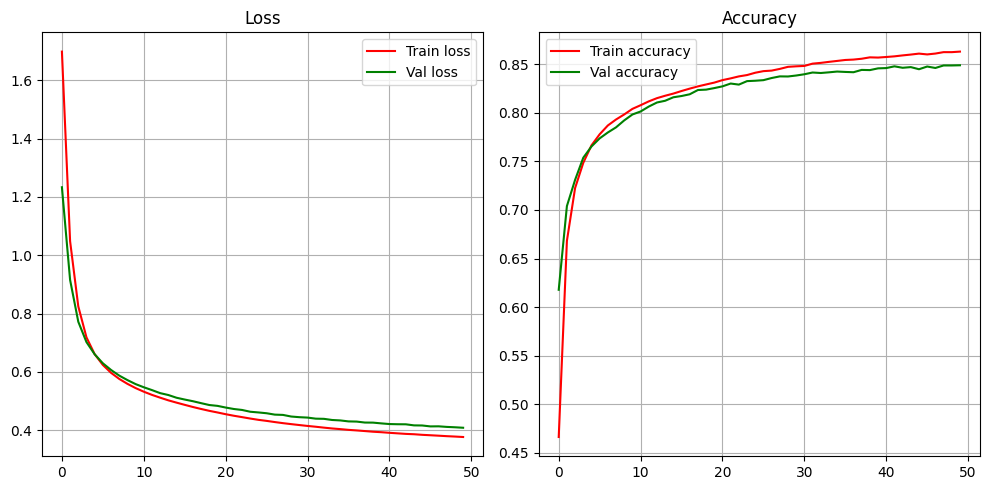

In [ ]:
graph_loss = {
    'values': [{
        'axy': epoch_t_loss_5,
        'color': 'r'
    },
    {
        'axy': epoch_v_loss_5,
        'color': 'g'
    }],
    'title': "Loss",
    'legend': ['Train loss', 'Val loss'],
}

graph_accuracy = {
    'values': [{
        'axy': epoch_t_acc_5,
        'color': 'r'
    },
    {
        'axy': epoch_v_acc_5,
        'color': 'g'
    }],
    'title': "Accuracy",
    'legend': ['Train accuracy', 'Val accuracy']
}

graphResults (graph_loss, graph_accuracy)

### Comparativa de los 5 modelos

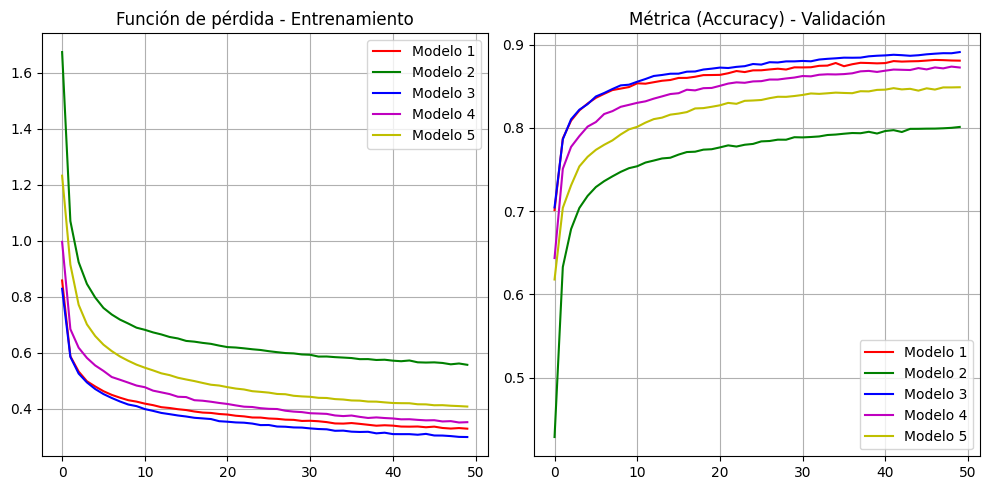

In [ ]:
graph_loss = {
    'values': [
      {
        'axy': epoch_t_loss_1,
        'color': 'r'
      },
      {
        'axy': epoch_t_loss_2,
        'color': 'g'
      },
      {
        'axy': epoch_t_loss_3,
        'color': 'b'
       },
       {
        'axy': epoch_t_loss_4,
        'color': 'm'
       },
       {
        'axy': epoch_v_loss_5,
        'color': 'y'
        }],
    'title': "Función de pérdida - Entrenamiento",
    'legend': ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5']
}

graph_accuracy = {
    'values': [
      {
        'axy': epoch_t_acc_1,
        'color': 'r'
      },
      {
        'axy': epoch_t_acc_2,
        'color': 'g'
      },
      {
        'axy': epoch_t_acc_3,
        'color': 'b'
       },
       {
        'axy': epoch_t_acc_4,
        'color': 'm'
       },
       {
        'axy': epoch_v_acc_5,
        'color': 'y'
        }],
    'title': "Métrica (Accuracy) - Validación",
    'legend': ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5']
}

graphResults (graph_loss, graph_accuracy)

In [ ]:
models_data = {
    'Modelo': ['CNN1', 'CNN2', 'CNN3', 'CNN4', 'CNN5'],
    'Total Params': [total_params_1, total_params_2, total_params_3, total_params_4, total_params_5],
    'Trainable Params': [trainable_params_1, trainable_params_2, trainable_params_3, trainable_params_4, trainable_params_5],
    'Non-Trainable Params': [non_trainable_params_1, non_trainable_params_2, non_trainable_params_3, non_trainable_params_4, non_trainable_params_5],
    'Input Size (MB)': [input_size_mb_1, input_size_mb_2, input_size_mb_3, input_size_mb_4, input_size_mb_5],
    'Forward/Backward Size (MB)': [forward_backward_size_mb_1, forward_backward_size_mb_2, forward_backward_size_mb_3, forward_backward_size_mb_4, forward_backward_size_mb_5],
    'Params Size (MB)': [params_size_mb_1, params_size_mb_2, params_size_mb_3, params_size_mb_4, params_size_mb_5],
    'Estimated Total Size (MB)': [estimated_total_size_mb_1, estimated_total_size_mb_2, estimated_total_size_mb_3, estimated_total_size_mb_4, estimated_total_size_mb_5],
}
df = pd.DataFrame(models_data)
display(df.style.hide(axis='index'))

Modelo,Total Params,Trainable Params,Non-Trainable Params,Input Size (MB),Forward/Backward Size (MB),Params Size (MB),Estimated Total Size (MB)
CNN1,47658,47658,0,0.000000,0.270000,0.180000,0.460000
CNN2,7690,7690,0,0.000000,0.090000,0.030000,0.120000
CNN3,98186,98186,0,0.000000,0.650000,0.370000,1.030000
CNN4,98186,98186,0,0.000000,0.720000,0.370000,1.100000
CNN5,6474,6474,0,0.000000,0.020000,0.020000,0.050000


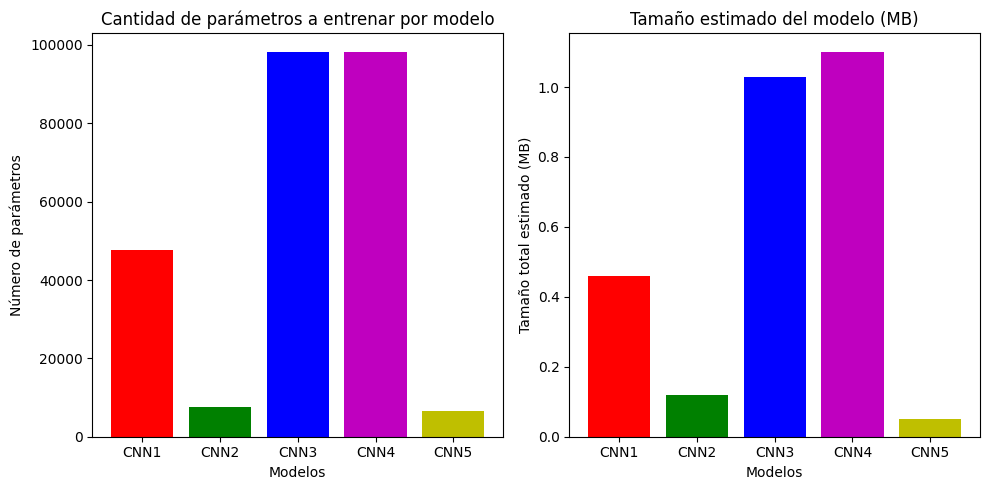

In [ ]:
categories = models_data['Modelo']
values1 = models_data['Total Params']
values2 = models_data['Estimated Total Size (MB)']
colors = ['r', 'g', 'b', 'm', 'y']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].bar(categories, values1, color=colors)
axs[0].set_title('Cantidad de parámetros a entrenar por modelo')
axs[0].set_xlabel('Modelos')
axs[0].set_ylabel('Número de parámetros')

axs[1].bar(categories, values2, color=colors)
axs[1].set_title('Tamaño estimado del modelo (MB)')
axs[1].set_xlabel('Modelos')
axs[1].set_ylabel('Tamaño total estimado (MB)')

plt.tight_layout()
plt.show()

### Conclusiones

En general, para las cinco arquitecturas probadas, las curvas de 'Loss' y 'Accuracy' en entrenamiento y validación son bastante similares.

Esto sugiere que el modelo logra generalizar bien, ya que no sólo se está ajustando bien a los datos de entrenamiento, si no que, también tiene buen desempeño con datos no vistos.

La evolución de las curvas a lo largo de 50 épocas no muestra indicios de sobreajuste.  El modelo no está "memorizando" los datos de entrenamiento, si no que, aprende patrones útiles que le permiten predecir correctamente sobre el conjunto de datos de validación.

La cantidad de datos de entrenamiento además es suficiente y las arquitecturas propuestas, sencillas, lo que permite también que el modelo aprenda de manera efectiva sin sobreajustarse.

De la comparación de los cinco modelos, los que logran mejor desempeño en términos de la métrica de evaluación son los modelos 1, 3 y 4.

Sin embargo, los modelos 3 y 4 tienen significativamente más parámetros entrenables que el 1 y por ende ocupan más recursos.

Esto era esperable ya que en éstos se introduce un bloque más de convolución que en el modelo 1.

Por otro lado, las curvas de validación de los modelos 3 y 4, si bien presentan la tendencia esperada, tienen algunas fluctuaciones o irregularidades a lo largo de las épocas.
Esto podría sugerir que el modelo es demasiado complejo para este set de datos y está intentando aprender patrones de más que puedan conducir a un sobreajuste.

En conclusión, selecciono la Arquitectura 1, que ofrece buenos resultados con menor complejidad.  
([CNN Comparación](https://drive.google.com/file/d/1CS-ZE8m5poe28GCN5LBFn8XCq3jf3Pex/view?usp=sharing))